<a href="https://colab.research.google.com/github/Jaew00/DeepLearning/blob/main/stock_pattern_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchvision import utils
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import glob
%matplotlib inline

import numpy as np
from torchvision import transforms 
from PIL import Image 
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import os

In [ ]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  with torch.no_grad() :
    for j, [imgs, labels] in enumerate(dloader) : # batch_size 만큼
      img = Variable(imgs, volatile = True).to(device) 
      label = Variable(labels).to(device)

      output = imodel.forward(img)
      _, output_index = torch.max(output, 1)

      total += label.size(0)
      correct += (output_index == label).sum().float()

  acc = 100*correct/total
  acc = float(acc.cpu().numpy())
  print("Accuracy of Test Data: {}".format(acc))
  return acc

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/btc_label.csv')
df

,Date,Price,Open,High,Low,Change,cal,Label,label
0,2017.9.26,4320000,4319000,4420000,4306000,0.000,1,2,1
1,2017.9.27,4654000,4320000,4680000,4313000,0.077,2,0,0
2,2017.9.28,4592000,4654000,4791000,4518000,-0.013,0,2,1
3,2017.9.29,4658000,4592000,4710000,4478000,0.014,2,2,1
4,2017.9.30,4891000,4658000,4898000,4654000,0.050,2,2,1
...,...,...,...,...,...,...,...,...,...
1672,2022.4.25,50633000,49617000,50897000,48560000,0.020,2,0,0
1673,2022.4.26,48710000,50623000,51147000,48202000,-0.038,0,2,1
1674,2022.4.27,49918000,48720000,50067000,48570000,0.025,2,2,1
1675,2022.4.28,50549000,49915000,51169000,49667000,0.013,2,0,0


In [ ]:
class Dataset(Dataset): 
    def __init__(self, path, train=True, transform=None): 
        df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/btc_label.csv')
        self.path = path 
        
        if train :
          self.train_path = path + '/train'
          self.train_list = glob.glob(self.train_path + '/*.jpg')
          self.img_list = self.train_list
        else :  
          self.test_path = path + '/test'
          self.test_list = glob.glob(self.test_path + '/*.jpg') 
          self.img_list = self.test_list
        
        
        self.transform = transform 
        
        self.Image_list = []  
        for img_path in self.img_list: 
            self.Image_list.append(Image.open(img_path))
        
        self.class_list = df['Label']
        
    def __len__(self): 
        return len(self.img_list)
    
    def __getitem__(self, idx): 
        img = self.Image_list[idx] 
        label = self.class_list[idx]
        
        if self.transform is not None: 
            img = self.transform(img) 
            
        
        return img, label 

if __name__ == "__main__": 
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]) 
    
    train_ds = Dataset(path='/content/drive/MyDrive/Colab Notebooks/btc_30min_jpg', train=True, transform=transform)
    trainloader = DataLoader(dataset=train_ds, batch_size=1, shuffle=True, drop_last=True)
    
    test_ds = Dataset(path='/content/drive/MyDrive/Colab Notebooks/btc_30min_jpg', train=False, transform=transform)
    testloader = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, drop_last=True)
     


In [ ]:
print(len(trainloader),
len(testloader))

1000 677


tensor(1)


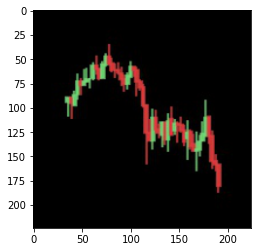

In [ ]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(torchvision.utils.make_grid(labels))

In [ ]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ELU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ELU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ELU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ELU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ELU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=3):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512        
        )
        self.fc_layer = nn.Sequential(
            
            nn.Linear(8*base_dim*7*7, 4096),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes),
            #nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [ ]:
batch_size = 100
learning_rate = 0.001
num_epoch = 10

In [ ]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

0 tensor(1.1034, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


Accuracy of Test Data: 34.56425476074219
0 tensor(1.4393, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 38.10930633544922
0 tensor(1.7975, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 34.56425476074219
0 tensor(0.5242, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 27.326438903808594
0 tensor(0.4704, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 38.10930633544922
0 tensor(2.4364, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 38.10930633544922
0 tensor(22.5484, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 38.10930633544922
0 tensor(5.8146, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 27.326438903808594
0 tensor(2.8887, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 38.10930633544922
0 tensor(8.5170, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of Test Data: 38.10930633544922


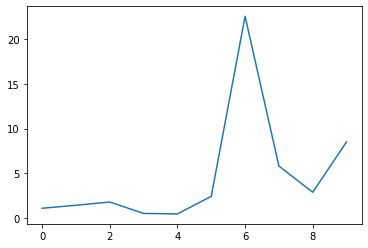

In [ ]:
from torch.utils.tensorboard import SummaryWriter

loss_arr = []
net_name = '/content/drive/MyDrive/Colab Notebooks/weights/best_weights1.pkl'
max_acc = 0

with SummaryWriter('runs') as writer :
  for i in range(num_epoch):
    model = model.train()

    for j, [image, label] in enumerate(trainloader):
      x=Variable(image).to(device)
      y_=Variable(label).to(device)

      optimizer.zero_grad()
      output=model.forward(x)
      loss=loss_func(output,y_)
      loss.backward()
      optimizer.step()
      #scheduler.step()

      if j%1000==0:
        print(j, loss)
        loss_arr.append(loss.cpu().detach().numpy())

    #model = torch.load(net_name)
    model.eval()
    acc = ComputeAccr(testloader, model)
    writer.add_scalar('accuracy', acc, num_epoch)

    if acc > max_acc :
      #print(acc)
      max_acc = acc
      torch.save(model, net_name)

  plt.plot(loss_arr)
  plt.show()